In [31]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape

from datetime import datetime
from tqdm.notebook import tqdm

In [4]:
surface_df_path = "data/clean_daylight_surface_ts.csv"

In [5]:
raw_df = pd.read_csv(surface_df_path)
raw_df["date_time"] = pd.to_datetime(raw_df["date_time"])
raw_df["plant_num"] = raw_df["plant_num"].astype(str)
raw_df["date"] = raw_df["date_time"].dt.normalize()
raw_df

,img_name,plant_num,date_time,surface,date
0,lettuce1_2024-06-15_07.jpg,1,2024-06-15 07:00:00,0.000000,2024-06-15
1,lettuce1_2024-06-15_08.jpg,1,2024-06-15 08:00:00,0.000000,2024-06-15
2,lettuce1_2024-06-15_09.jpg,1,2024-06-15 09:00:00,0.000000,2024-06-15
3,lettuce1_2024-06-15_10.jpg,1,2024-06-15 10:00:00,0.000000,2024-06-15
4,lettuce1_2024-06-15_11.jpg,1,2024-06-15 11:00:00,0.000000,2024-06-15
...,...,...,...,...,...
5499,lettuce8_2024-07-26_12.jpg,8,2024-07-26 12:00:00,281.915085,2024-07-26
5500,lettuce8_2024-07-26_13.jpg,8,2024-07-26 13:00:00,281.886747,2024-07-26
5501,lettuce8_2024-07-26_14.jpg,8,2024-07-26 14:00:00,280.357834,2024-07-26
5502,lettuce8_2024-07-26_15.jpg,8,2024-07-26 15:00:00,281.198534,2024-07-26


In [6]:
df = raw_df.groupby(["plant_num", "date"])["surface"].mean().sort_index().reset_index()
df["days_from_start"] = (df["date"] - df.groupby('plant_num')["date"].transform('min')).dt.days
mean_df = df.groupby("days_from_start")["surface"].mean().sort_index().reset_index()
df.head()

,plant_num,date,surface,days_from_start
0,1,2024-06-15,0.000000,0
1,1,2024-06-16,0.158717,1
2,1,2024-06-17,0.340680,2
3,1,2024-06-18,0.523646,3
4,1,2024-06-19,0.351673,4


## Data preprocessing for ARIMA

In [7]:
def plot_ts(x, y, df, hue=None):
    fig = plt.figure(figsize=(12, 6))

    if hue:
        sns.lineplot(x=x, y=y, data=df, hue=hue)
    else:
        sns.lineplot(x=x, y=y, data=df)
    plt.xlabel('Date Time')
    plt.ylabel('Surface cm2')
    plt.title('Plant surface cm2 over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

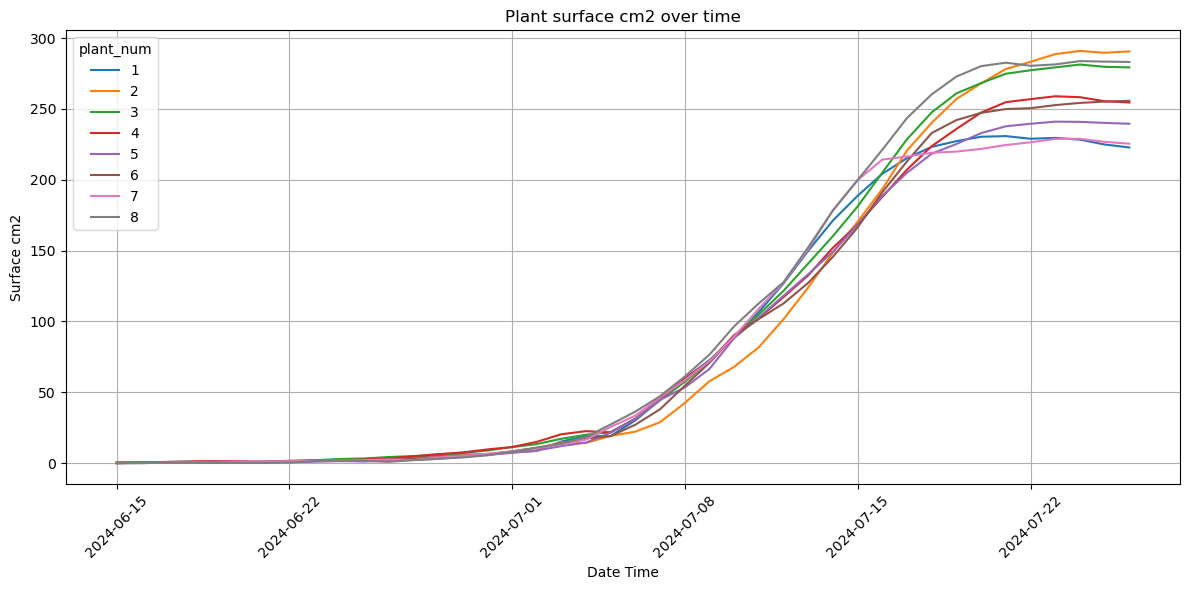

In [8]:
plot_ts(x="date", y="surface", df=df, hue="plant_num")

**First order diff**

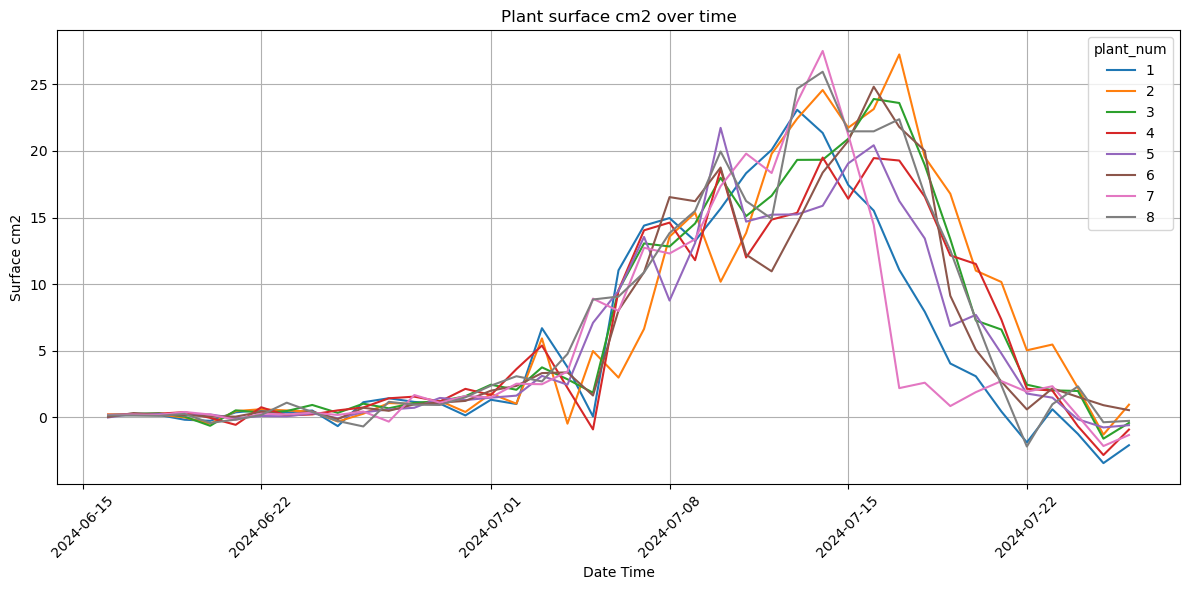

In [9]:
df["surface_diff"] = df.groupby("plant_num")["surface"].diff()
plot_ts(x="date", y="surface_diff", df=df, hue="plant_num")

**Second order diff**

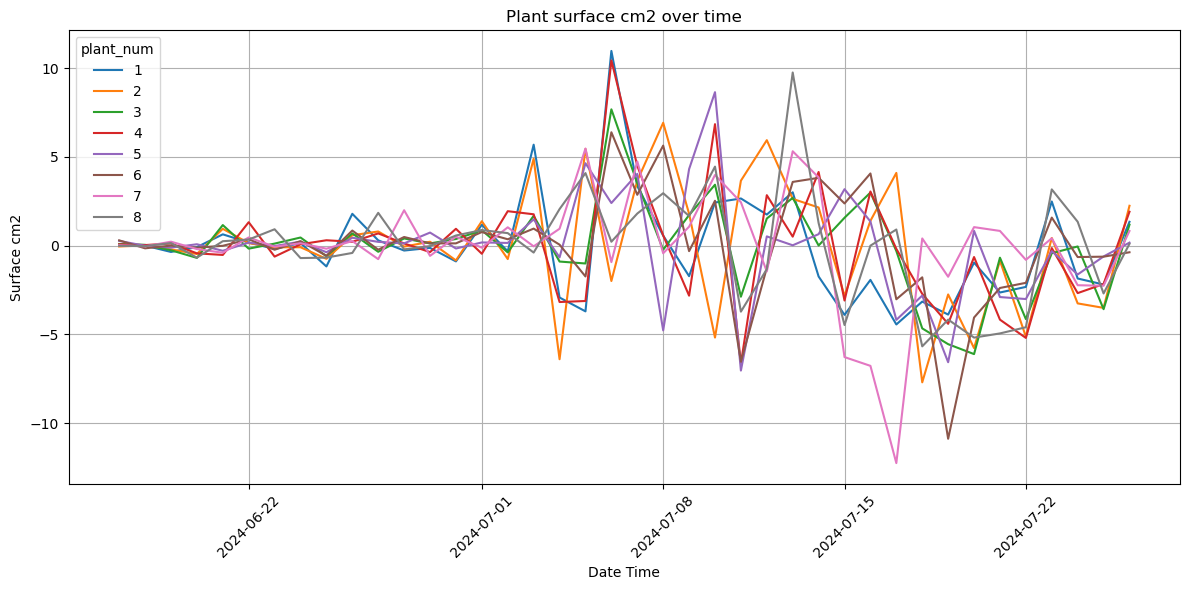

In [10]:
df["surface_diff2"] = df.groupby("plant_num")["surface_diff"].diff()
plot_ts(x="date", y="surface_diff2", df=df, hue="plant_num")

**Third order differencing**

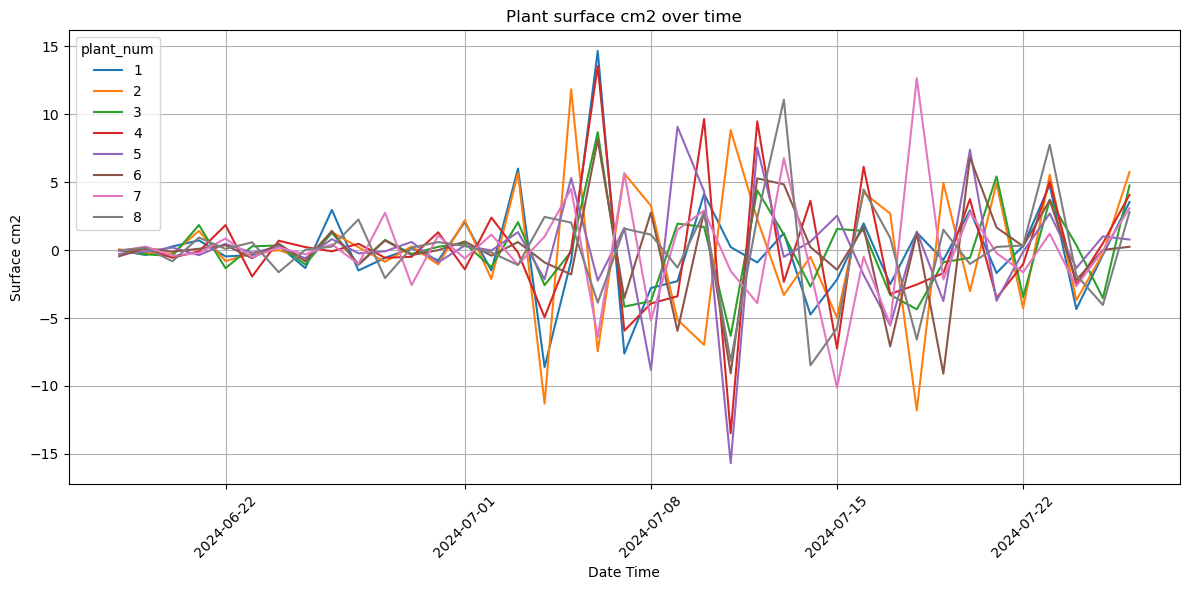

In [11]:
df["surface_diff3"] = df.groupby("plant_num")["surface_diff2"].diff()
plot_ts(x="date", y="surface_diff3", df=df, hue="plant_num")

In [12]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the surface area data
adf_test = []
for plant in tqdm(range(1, 9)):
    result = adfuller(df[df["plant_num"] == str(plant)]['surface_diff3'].dropna())
    verdict = result[1] < 0.05
    adf_test.append([plant, result[0], result[1], verdict])
adf_test = pd.DataFrame(adf_test, columns=["plant", "ADF statistic", "p-value", "is_stationary"])
adf_test

  0%|          | 0/8 [00:00<?, ?it/s]

,plant,ADF statistic,p-value,is_stationary
0,1,-8.548894,9.339198e-14,True
1,2,-5.390267,3.550346e-06,True
2,3,-7.932970,3.473254e-12,True
3,4,-3.889988,2.109776e-03,True
4,5,-5.437461,2.824632e-06,True
5,6,-2.044175,2.675457e-01,False
6,7,-9.433590,5.112345e-16,True
7,8,-10.202807,5.909451e-18,True


## ARIMA

In [27]:
train_plants = ["1", "2", "3", "4", "5", "6"]
test_plants = ["7", "8"]

train_df = df[df['plant_num'].isin(train_plants)]
test_df7 = df[df['plant_num'] == test_plants[0]]

In [15]:
train_gap_df = []
gap_days = 10
for plant in train_plants:
    temp_df = train_df[train_df["plant_num"] == plant].copy()
    last_date = temp_df['date'].max()
    last_day = temp_df["days_from_start"].max()
    nan_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                  periods=gap_days, 
                                  freq='D')
    nan_days = list(range(last_day + 1, last_day + gap_days + 1, 1))
    nan_df = pd.DataFrame({'plant_num': [plant] * gap_days, 
                           'date': nan_dates, 
                           'surface': [np.nan] * gap_days,
                           'days_from_start': nan_days})
    train_gap_df.append(pd.concat([temp_df, nan_df]))
train_gap_df = pd.concat(train_gap_df)

In [22]:
train_gap_df

,plant_num,date,surface,days_from_start,surface_diff,surface_diff2,surface_diff3
0,1,2024-06-15,0.000000,0,NaN,NaN,NaN
1,1,2024-06-16,0.158717,1,0.158717,NaN,NaN
2,1,2024-06-17,0.340680,2,0.181963,0.023246,NaN
3,1,2024-06-18,0.523646,3,0.182966,0.001003,-0.022243
4,1,2024-06-19,0.351673,4,-0.171973,-0.354939,-0.355942
...,...,...,...,...,...,...,...
5,6,2024-08-01,NaN,47,NaN,NaN,NaN
6,6,2024-08-02,NaN,48,NaN,NaN,NaN
7,6,2024-08-03,NaN,49,NaN,NaN,NaN
8,6,2024-08-04,NaN,50,NaN,NaN,NaN


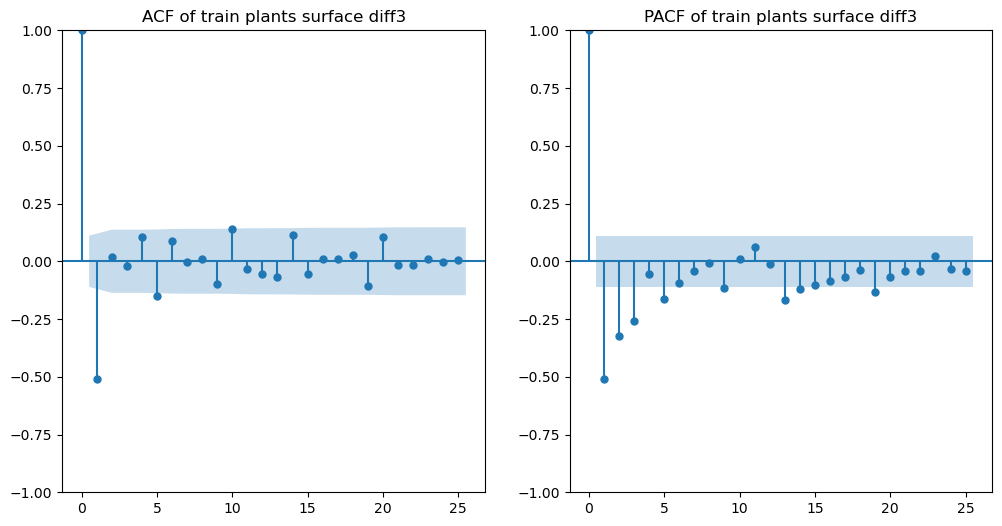

In [20]:
# Step 7: Plot ACF and PACF for this time series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ACF and PACF plots
plot_acf(train_gap_df["surface_diff3"].fillna(0), ax=ax1, title="ACF of train plants surface diff3")
plot_pacf(train_gap_df["surface_diff3"].fillna(0), ax=ax2, title="PACF of train plants surface diff3");

In [23]:
p=4
d=3
q=2

In [32]:
# Maximum horizon of forecasting
X = 5

# Initialize lists to store errors and predictions
mae_list = []
mape_list = []
predictions = {f'{i}_day_ahead': [] for i in range(1, X + 1)}

# Iterate through test days, starting from the point where we have at least p test points
for i in tqdm(range(p, len(test_df7))):
    # Combine train data and first i days of test data
    current_train_df = pd.concat([train_gap_df, test_df7.iloc[:i]])

    # Prepare time series for ARIMA
    time_series = current_train_df['surface'].values

    # Fit ARIMA model
    model = ARIMA(time_series, order=(p, d, q))
    fitted_model = model.fit()

    # Make predictions for the next X days (forecasting horizon)
    forecast = fitted_model.get_forecast(steps=X).predicted_mean

    # Compare with the actual test data for the next X days
    actuals = test_df7['surface'].iloc[i:i+X].values

    # Store predictions and calculate errors
    for j in range(1, X + 1):
        if i + j <= len(test_df7):
            pred_value = forecast[j-1]
            true_value = actuals[j-1]
            predictions[f'{j}_day_ahead'].append((true_value, pred_value))

# Calculate MAE and MAPE for each horizon
for horizon in range(1, X + 1):
    true_vals = [x[0] for x in predictions[f'{horizon}_day_ahead']]
    pred_vals = [x[1] for x in predictions[f'{horizon}_day_ahead']]

    mae_ = mae(true_vals, pred_vals)
    mape_ = mape(np.array(true_vals), np.array(pred_vals))

    mae_list.append(mae_)
    mape_list.append(mape_)

  0%|          | 0/38 [00:00<?, ?it/s]

C:\Users\dmitr\.conda\envs\unimi-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dmitr\.conda\envs\unimi-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dmitr\.conda\envs\unimi-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
for i in range(X):
    print(f"{i+1}-day ahead: MAE = {mae_list[i]}, MAPE = {mape_list[i] * 100}%") 

1-day ahead: MAE = 2.0745015924895545, MAPE = 10.868488061323953%
2-day ahead: MAE = 4.903832568564917, MAPE = 20.82143612608241%
3-day ahead: MAE = 9.04143089017639, MAPE = 30.045707574944835%
4-day ahead: MAE = 13.87510145067141, MAPE = 39.20815287936387%
5-day ahead: MAE = 19.53718576117352, MAPE = 45.374650052398266%


<Figure size 1000x600 with 0 Axes>

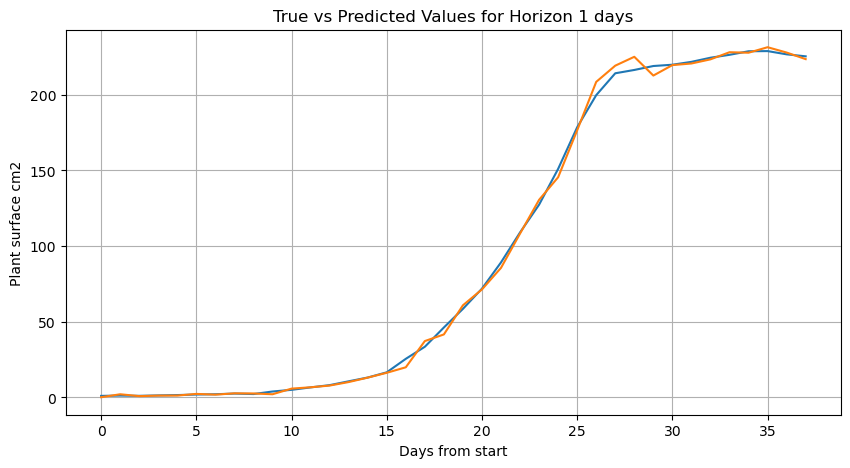

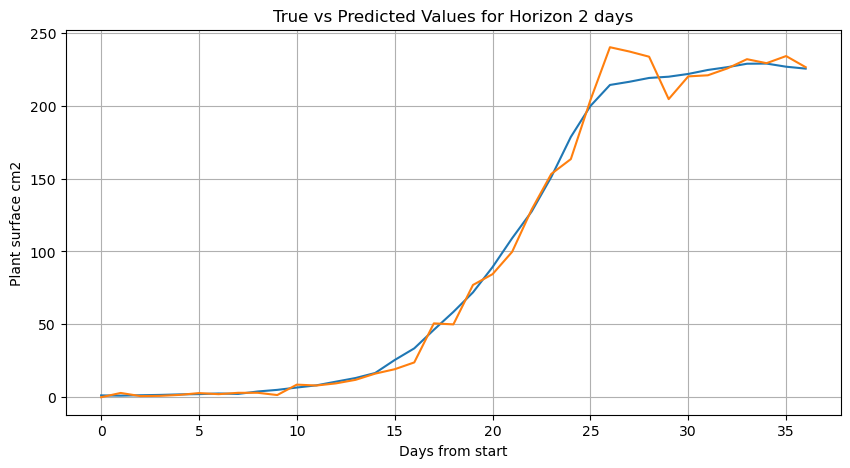

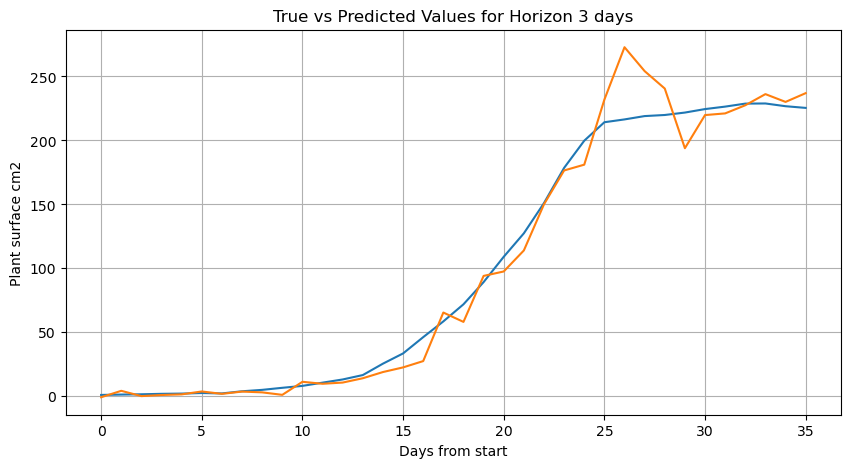

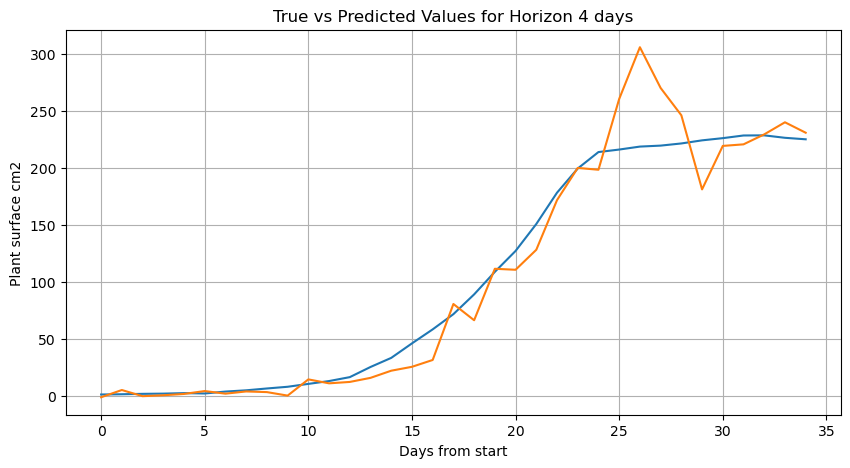

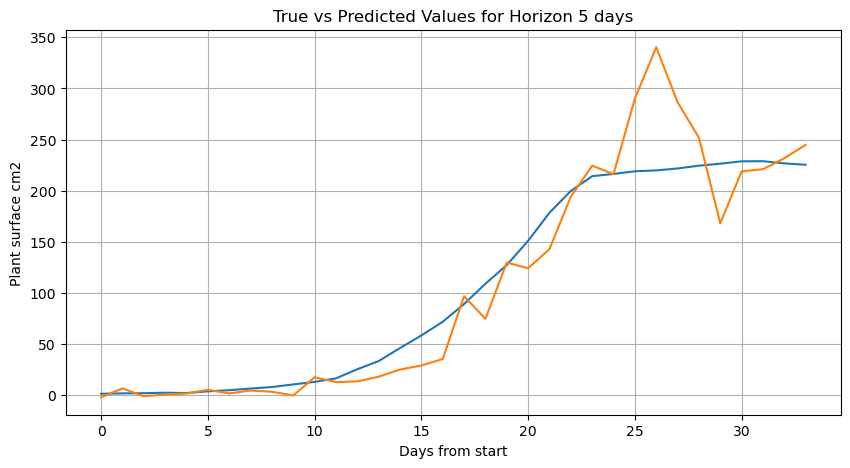

In [42]:
plt.figure(figsize=(10, 6))
for horizon in range(1, X + 1):
    true_vals = [x[0] for x in predictions[f'{horizon}_day_ahead']]
    pred_vals = [x[1] for x in predictions[f'{horizon}_day_ahead']]
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(true_vals)
    plt.plot(pred_vals)
    plt.grid()
    plt.xlabel("Days from start")
    plt.ylabel("Plant surface cm2")
    plt.title(f"True vs Predicted Values for Horizon {horizon} days")
    plt.show()